<a href="https://colab.research.google.com/github/viniciusrpb/cic0269_natural_language_processing/blob/main/lectures/aula_named_entity_recognition_crf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capítulo 14: Reconhecimento de Entidades Nomeadas


## 14.2. Conditional Random Fields

https://github.com/howl-anderson/addons/blob/add_crf_tutorial/docs/tutorials/layers_crf.ipynb


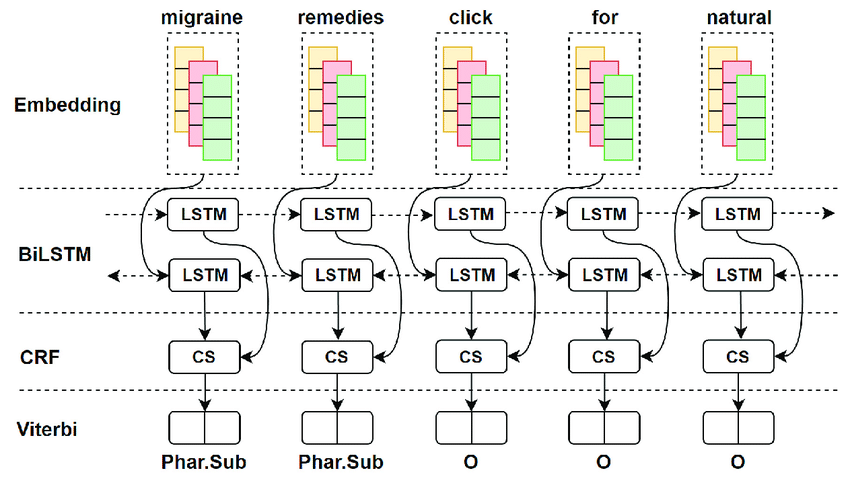

Fonte da Imagem: Batbaatar, E., & Ryu, K. H. (2019). Ontology-based healthcare named entity recognition from twitter messages using a recurrent neural network approach. International journal of environmental research and public health, 16(19), 3628.

In [ ]:
#!pip install -U tensorflow-datasets
#!pip install keras
#!pip install tensorflow
!pip install tensorflow-addons[tensorflow]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import pandas as pd
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Activation,Embedding,Dropout,LSTM,Bidirectional,TimeDistributed,Input,Reshape
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report
from tensorflow_addons.text.crf_wrapper import CRFModelWrapper
from tensorflow_addons.layers.crf import CRF
from collections import Counter
import tensorflow_addons as tfa

In [ ]:
def preprocessDataFrame(df):

    dic = {}
    dic['tokens'] = []

    for text in df['tokens']:
        tokens = []
        for x in text:
            tokens.append(x.decode('utf-8'))
        l = " ".join(tokens)
        dic['tokens'].append(l.split())
        
    res_df = pd.DataFrame.from_dict(dic)
    res_df['ner'] = df['ner']
    return res_df

In [ ]:
ds_train = tfds.load('conll2003', split='train', shuffle_files=True)
ds_valid = tfds.load('conll2003', split='dev', shuffle_files=False)
ds_test = tfds.load('conll2003', split='test', shuffle_files=False)

In [ ]:
df_train = preprocessDataFrame(tfds.as_dataframe(ds_train))
df_valid = preprocessDataFrame(tfds.as_dataframe(ds_valid))
df_test = preprocessDataFrame(tfds.as_dataframe(ds_test))

In [ ]:
df_train

,tokens,ner
0,"["", If, they, 're, saying, at, least, 20, perc...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[Lauck, 's, lawyer, vowed, he, would, appeal, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[Thailand, 's, powerful, military, thinks, the...","[5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, ..."
3,"[A, forensic, scientist, who, examined, the, s...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
4,"[Werder, Bremen, 3, 0, 1, 2, 4, 6, 1]","[3, 4, 0, 0, 0, 0, 0, 0, 0]"
...,...,...
14037,"["", He, was, not, involved, ...]","[0, 0, 0, 0, 0, 0]"
14038,"["", It, goes, without, saying, that, we, 're, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
14039,"[Bowling, :]","[0, 0]"
14040,"[National, League]","[7, 8]"


In [ ]:
def label2int():
    iob_labels = ["B", "I"]
    ner_labels = ["PER", "ORG", "LOC", "MISC"]
    all_labels = [(label1, label2) for label2 in ner_labels for label1 in iob_labels]
    all_labels = ["-".join([a, b]) for a, b in all_labels]
    dic = dict(zip(range(1, len(all_labels) + 1), all_labels))
    dic[0] = 'O'
    return dic 

In [ ]:
int2tag = label2int()

int2tag

{1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC',
 7: 'B-MISC',
 8: 'I-MISC',
 0: 'O'}

In [ ]:
tag2int = {}
for key in int2tag:
    value = int2tag[key]
    tag2int[value] = key
print(tag2int)

num_labels = len(tag2int)

{'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8, 'O': 0}


Cria o vocabulário

In [ ]:
word2index = {}
word2index['<OOV>'] = 0
word2index['<BEG>'] = 1
word2index['<END>'] = 2

ind = 3
for text in df_train['tokens']:
    for word in text:
        if word not in word2index:
            word2index[word] = ind
            ind+=1

index2word = {}
for key in word2index:
    value = word2index[key]
    index2word[value] = key

In [ ]:
def rebuild_datasets(df,labels):

    data = []
    novel_labels = []

    idx = 0
    for text in df:

        data.append(['<BEG>'])
        novel_labels.append(0)

        for i in range(0,len(text)):
            lista = ['<BEG>']+text[:i+1]
            data.append(lista)
            if i < len(text)-1:
                novel_labels.append(labels[idx][i])
            else:
                novel_labels.append(0)
        idx+=1

        data.append(lista+['<END>'])
        novel_labels.append(0)

    return data,novel_labels

In [ ]:
x_train,y_train_int = rebuild_datasets(df_train['tokens'],df_train['ner'])
x_valid,y_valid_int = rebuild_datasets(df_valid['tokens'],df_valid['ner'])
x_test,y_test_int = rebuild_datasets(df_test['tokens'],df_test['ner'])

Verificando se está tudo certo

In [ ]:
for i,word in enumerate(x_train[33]):
    print(f'Word: {word} text label: {int2tag[y_train_int[i]]} int label: {y_train_int[i]} ')

Word: <BEG> text label: O int label: 0 
Word: " text label: O int label: 0 
Word: If text label: O int label: 0 
Word: they text label: O int label: 0 
Word: 're text label: O int label: 0 
Word: saying text label: O int label: 0 
Word: at text label: O int label: 0 
Word: least text label: O int label: 0 
Word: 20 text label: O int label: 0 
Word: percent text label: O int label: 0 
Word: , text label: O int label: 0 
Word: then text label: O int label: 0 
Word: their text label: O int label: 0 
Word: internal text label: O int label: 0 
Word: forecasts text label: O int label: 0 
Word: are text label: O int label: 0 
Word: probably text label: O int label: 0 
Word: saying text label: O int label: 0 
Word: 25 text label: O int label: 0 
Word: or text label: O int label: 0 
Word: 30 text label: O int label: 0 
Word: percent text label: O int label: 0 
Word: , text label: O int label: 0 
Word: " text label: O int label: 0 
Word: said text label: O int label: 0 
Word: one text label: O i

In [ ]:
max_length = max([len(sentence) for sentence in x_train])
max_length

115

In [ ]:
def text2sequences(data,vocab):
    corpus_int = []
    for instance in data:
        instance_int = []
        for term in instance:
            if term in vocab:
                instance_int.append(vocab[term])
            else:
                instance_int.append(vocab['<OOV>'])
        corpus_int.append(instance_int)
    
    return corpus_int

In [ ]:
train_sequences = text2sequences(x_train,word2index)
valid_sequences = text2sequences(x_valid,word2index)
test_sequences = text2sequences(x_test,word2index)

In [ ]:
trunc_type = 'post'
padding_type = 'pre'

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
y_train = to_categorical(y_train_int)
#y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
#y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], 1))
#y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))
#y_train = np.expand_dims(y_train,2)
y_valid = to_categorical(y_valid_int)
#y_valid = np.expand_dims(y_valid,2)
y_test = to_categorical(y_test_int)
#y_test = np.expand_dims(y_test,2)

In [ ]:
vocab_size = len(word2index)

In [ ]:
backbone = Sequential()
backbone.add(Embedding(input_dim=vocab_size+3,output_dim=64,input_length=max_length))
backbone.add(Bidirectional(LSTM(256,activation='relu')))
backbone.add(Dropout(0.5))
backbone.add(Dense(num_labels,activation='softmax'))
backbone.add(Reshape(target_shape=(num_labels,1)))

model = CRFModelWrapper(backbone, num_labels)

In [ ]:
f1scoretfa = tfa.metrics.F1Score(num_classes=num_labels, average='macro',threshold=0.5)

sgd = SGD(learning_rate = 0.00005)
model.compile(optimizer=sgd)
#model.compile(optimizer="rmsprop")
history_fine = model.fit(train_padded,y_train,batch_size=64,validation_data=(valid_padded,y_valid),epochs=10)

Epoch 1/10
3621/3621 [==============================] - 4487s 1s/step - loss: 3.2673 - crf_loss: 3.2673 - val_loss: 1.0748 - val_crf_loss: 1.0748
Epoch 2/10
3621/3621 [==============================] - 4527s 1s/step - loss: 1.4663 - crf_loss: 1.4663 - val_loss: 0.5967 - val_crf_loss: 0.5967
Epoch 3/10
3621/3621 [==============================] - 4450s 1s/step - loss: 1.2867 - crf_loss: 1.2867 - val_loss: 0.4564 - val_crf_loss: 0.4564
Epoch 4/10
 822/3621 [=====>........................] - ETA: 53:04 - loss: 1.2340 - crf_loss: 1.2340

In [ ]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_fine.history['f1_score'])
plt.plot(history_fine.history['val_f1_score'])
plt.title('model f1 score')
plt.ylabel('f1score')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

Teste

In [ ]:
y_prob = model.predict(test_padded)
y_pred = np.argmax(y_prob,axis=1)

In [ ]:
print(classification_report(y_test_int,y_pred))

Deployment

In [ ]:
sentenca_teste = ["Mayara is living in Spain which its land urges for coffee".split()]
sentenca_int = text2sequences(sentenca_teste,word2index)
sentenca_padded = pad_sequences(sentenca_int, maxlen=max_length, padding=padding_type, truncating=trunc_type)

y_prob = model.predict(sentenca_padded)
y_pred = np.argmax(y_prob,axis=1)

for idx,word in enumerate(sentenca_teste):
    print(f'{word} is label {int2tag[y_pred[idx]]}')